<a href="https://colab.research.google.com/github/nisharonn/US-Economic-Recovery-Post-COVID-19/blob/main/MLR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiple Logistic Regression

**Goal:** Build a binary **multiple logistic regression** model to predict **`spend recovered`** (0 = net change < 0, 1 = net change >= 0) and **`emp recovered`** (0 = net change < 0, 1 = net change >= 0) from predictors. Predict which states are expected to make a full recovery in both employment and consumer spending after 5 years.


## 0) Setup (imports)

In [33]:
!pip install -q ISLP statsmodels scikit-learn pandas numpy matplotlib
!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 120)

## 0) Load Dataset


In [34]:
df = pd.read_csv('data.csv')
print(df.shape)
df.head()

(3519, 56)


,statename,year,month,spend apparel and accessories,spend accommodation and food services,"spend arts, entertainment, and recreation",spend all,spend general merchandise + apparel,spend durable goods,spend general merchandise,spend grocery and food stores,spend health care and social assistance,spend home improvement centers,spend other in-person services,spend non-durable goods,spend remote services,spend transportation and warehousing,spend all_incmiddle,spend all q1,spend all q2,spend all q3,spend all q4,spend in-person services,spend retail excluding grocery,spend retail including grocery,day_endofweek,emp all,emp q1,emp q2,emp q3,emp q4,emp inc middle,emp inc below_median,emp inc above median,emp trade_transport utilities,emp professional business_services,emp education health services,emp leisure hospitality,case_rate,death_rate,test_rate,vaccine_rate,fullvaccine_rate,booster_first_rate,hospitalized_rate,day,time retail and recreation,time grocery and pharmacy,time parks,time transit stations,time workplaces,time residential,time away from home,spend_recovered,emp_recovered,fully_recovered
0,Alabama,2020,1,0.0000,-1.910000e-09,0.0000,0.0000,-2.880000e-08,3.280000e-08,0.0000,0.0000,3.870000e-08,0.0000,0.0000,8.600000e-08,-6.630000e-09,0.0000,8.100000e-08,0.0000,0.0000,0.0000,0.0000,-3.680000e-08,-4.440000e-08,4.360000e-08,31.0,-0.00474,-0.01700,0.00717,-0.00084,-0.00768,0.00311,-0.00574,-0.00343,-0.0355,-0.00263,0.0107,-0.0168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
1,Alabama,2020,2,-0.0438,2.160000e-02,0.0643,0.0278,2.020000e-02,1.250000e-02,0.0782,0.0935,-1.310000e-02,0.0341,-0.0368,2.490000e-02,4.500000e-02,-0.0412,8.730000e-03,0.0514,-0.0106,0.0348,0.0408,2.190000e-04,2.340000e-02,5.010000e-02,28.0,0.01510,0.00845,0.01100,0.02940,0.01040,0.02030,0.00962,0.02220,0.0163,-0.00342,0.0505,-0.0200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,0.0900,0.0414,0.191,0.1070,0.010,-0.00571,0.00855,True,True,True
2,Alabama,2020,3,-0.3510,-3.800000e-01,-0.3730,-0.0898,-1.460000e-01,-3.850000e-02,0.0646,0.3740,-1.610000e-01,0.0591,-0.1770,1.830000e-02,-2.870000e-02,-0.4600,-1.050000e-01,-0.0571,-0.1090,-0.0996,-0.1080,-3.280000e-01,-8.410000e-02,8.000000e-02,27.0,-0.09350,-0.19800,-0.07090,-0.03170,-0.03860,-0.05100,-0.13900,-0.03430,-0.1420,-0.05530,-0.0833,-0.3190,3.848895,0.017158,NaN,NaN,NaN,NaN,0.101591,31.0,-0.3340,-0.0643,0.180,-0.2340,-0.344,0.13100,-0.15900,False,False,False
3,Alabama,2020,4,-0.5350,-6.060000e-01,-0.6520,-0.2290,-3.190000e-01,1.530000e-02,-0.0916,0.1650,-5.770000e-01,0.2300,-0.4660,-1.700000e-01,-1.210000e-01,-0.6440,-2.620000e-01,-0.1630,-0.2700,-0.2520,-0.2620,-5.840000e-01,-1.450000e-01,-3.380000e-02,24.0,-0.21500,-0.41300,-0.18600,-0.10800,-0.07350,-0.14700,-0.30700,-0.09520,-0.2700,-0.17100,-0.2360,-0.5410,72.970000,2.257533,NaN,NaN,NaN,NaN,7.704000,30.0,-0.2400,-0.0300,0.143,-0.2300,-0.347,0.12100,-0.14800,False,False,False
4,Alabama,2020,5,-0.1820,-3.820000e-01,-0.4720,-0.1010,-7.270000e-02,1.720000e-01,0.0279,0.1500,-2.450000e-01,0.3840,-0.1990,-5.330000e-02,-5.080000e-02,-0.6160,-1.330000e-01,-0.0346,-0.1550,-0.1030,-0.1400,-3.680000e-01,1.160000e-01,1.290000e-01,29.0,-0.17200,-0.30000,-0.13100,-0.13200,-0.06780,-0.13100,-0.22100,-0.10700,-0.2040,-0.28300,-0.1220,-0.2460,224.387097,8.786129,NaN,NaN,NaN,NaN,8.569677,31.0,-0.0914,0.0314,0.373,-0.0371,-0.236,0.08290,-0.09430,False,False,False


In [35]:
df.columns

Index(['statename', 'year', 'month', 'spend apparel and accessories', 'spend accommodation and food services',
       'spend arts, entertainment, and recreation', 'spend all', 'spend general merchandise + apparel', 'spend durable goods',
       'spend general merchandise', 'spend grocery and food stores', 'spend health care and social assistance',
       'spend home improvement centers', 'spend other in-person services', 'spend non-durable goods', 'spend remote services',
       'spend transportation and warehousing', 'spend all_incmiddle', 'spend all q1', 'spend all q2', 'spend all q3', 'spend all q4',
       'spend in-person services', 'spend retail excluding grocery', 'spend retail including grocery', 'day_endofweek', 'emp all',
       'emp q1', 'emp q2', 'emp q3', 'emp q4', 'emp inc middle', 'emp inc below_median', 'emp inc above median',
       'emp trade_transport utilities', 'emp professional business_services', 'emp education health services', 'emp leisure hospitality',
       

## 1) EDA
1. Count the number of `spend_recovered=0` and `spend_recovered=1`, `emp recovered=0` and `emp recovered=1`  

In [36]:
df.describe()

,year,month,spend apparel and accessories,spend accommodation and food services,"spend arts, entertainment, and recreation",spend all,spend general merchandise + apparel,spend durable goods,spend general merchandise,spend grocery and food stores,spend health care and social assistance,spend home improvement centers,spend other in-person services,spend non-durable goods,spend remote services,spend transportation and warehousing,spend all_incmiddle,spend all q1,spend all q2,spend all q3,spend all q4,spend in-person services,spend retail excluding grocery,spend retail including grocery,day_endofweek,emp all,emp q1,emp q2,emp q3,emp q4,emp inc middle,emp inc below_median,emp inc above median,emp trade_transport utilities,emp professional business_services,emp education health services,emp leisure hospitality,case_rate,death_rate,test_rate,vaccine_rate,fullvaccine_rate,booster_first_rate,hospitalized_rate,day,time retail and recreation,time grocery and pharmacy,time parks,time transit stations,time workplaces,time residential,time away from home
count,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3519.000000,3315.000000,3280.000000,3244.000000,3280.000000,3280.000000,1224.000000,3280.000000,3244.000000,1224.000000,3150.000000,3280.000000,3215.000000,3055.000000,2003.000000,3380.000000,1469.000000,1428.000000,1377.000000,1020.000000,2573.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000
mean,2022.391304,6.304348,0.042141,0.045264,0.147434,0.177952,0.286762,0.132667,0.459256,0.149373,0.185472,0.208694,0.119939,0.164614,0.308615,-0.020483,0.170979,0.176988,0.169627,0.169489,0.146518,0.067415,0.232391,0.192454,27.030769,-0.039927,-0.126633,-0.038679,0.006049,-0.009568,-0.018065,-0.068231,-0.027302,-0.039206,0.047062,-0.085034,-0.179739,15776.323647,261.671075,144734.304239,66.707902,57.988796,28.990511,11.560909,29.939394,-0.096377,-0.009460,0.537300,-0.129490,-0.246226,0.063075,-0.072354
std,1.661538,3.389742,0.196017,0.202511,0.418416,0.156488,0.226672,0.113855,0.322728,0.097076,0.273314,0.209647,0.218307,0.113146,0.229159,0.363315,0.151715,0.166422,0.172215,0.150985,0.161515,0.229921,0.147659,0.103461,3.795181,0.107801,0.167442,0.144971,0.128930,0.065027,0.127745,0.127245,0.067096,0.131248,0.170862,0.125142,0.173515,11819.776826,140.377884,135579.056142,20.735702,16.322752,11.471330,11.712312,2.763554,0.138393,0.099443,0.719997,0.236158,0.103850,0.043473,0.054021
min,2020.000000,1.000000,-0.651000,-0.788000,-0.805000,-0.480000,-0.545000,-0.234000,-0.419000,-0.270000,-0.902000,-0.434000,-0.650000,-0.297000,-0.309000,-0.893000,-0.543000,-0.524000,-0.701000,-0.538000,-0.469000,-0.780000,-0.398000,-0.214000,2.000000,-0.359000,-0.671000,-0.489000,-0.298000,-0.260000,-0.389000,-0.478000,-0.259000,-0.432000,-0.299000,-0.453000,-0.770000,0.004177,0.000000,0.000000,7.212500,8.927037,0.897500,0.000000,15.000000,-0.643000,-0.331000,-0.669000,-0.757000,-0.634000,-0.018600,-0.294000
25%,2021.000000,3.000000,-0.029350,-0.031450,-0.088750,0.066700,0.141000,0.051200,0.223000,0.094500,0.031000,0.071050,-0.006310,0.093050,0.129000,-0.234000,0.066500,0.046900,0.048700,0.065950,0.028400,-0.045050,0.150000,0.131000,26.000000,-0.099125,-0.230000,-0.110000,-0.067125,-0.043550,-0.083225,-0.140000,-0.061200,-0.111000,-0.039500,-0.150000,-0.280000,4199.161828,161.000000,35979.129032,58.221694,51.496774,22.247500,3.660323,30.000000,-0.163000,-0.068600,0.013600,-0.291000,-0.306000,0.032900,-0.102000
50%,2022.000000,6.000000,0.045900,0.077700,0.117000,0.187000,0.282000,0.135000,0.425000,0.147000,0.179000,0.196000,0.115000,0.175000,0.291000,0.000000,0.179000,0.189000,0.177000,0.180000,0.153000,0.087900,0.230000,0.194000,27.000000,-0.057350,-0.159000,-0.043050,-0.023550,-0.010400,-0.03

In [47]:
df_jan = df[(df['month'] == 1) & (df['year'] == 2022)]
predictors = ['case_rate','death_rate','vaccine_rate', 'hospitalized_rate', 'test_rate']

X = df_jan[predictors].dropna()

display(df_jan['spend_recovered'].value_counts(dropna=False))
display(df_jan['spend_recovered'].value_counts(normalize=True))

display(df_jan['emp_recovered'].value_counts(dropna=False))
display(df_jan['emp_recovered'].value_counts(normalize=True))

for col in ['case rate','time workplaces']:
    if col in df.columns:
        display(df[[col]].describe())

,count
spend_recovered,
True,44
False,7


,proportion
spend_recovered,
True,0.862745
False,0.137255


,count
emp_recovered,
False,38
True,13


,proportion
emp_recovered,
False,0.745098
True,0.254902


,time workplaces
count,1683.000000
mean,-0.246226
std,0.103850
min,-0.634000
25%,-0.306000
50%,-0.240000
75%,-0.183000
max,0.060000


## 2) Prepare data for fitting
**We define:**
- **Outcome:** `spend_recovered`, `emp recovered` (0 = net change < 0, 1 = net change >= 0)
- **Predictors:** `spend all`,`emp all`,`case_rate`, `time away from home`

Cleaning up the training data (ensure no NaNs):
1. Use `df.dropna` to drop any row that has a missing value in 'status'
2. `subset=['spend_recovered', 'emp_recovered'] + predictors` combines the outcome with the predictors so all required columns must be non-missing.
3. `.copy()` makes a new data frame

In [48]:
data = df_jan.dropna(subset=['spend_recovered', 'emp_recovered'] + predictors).copy()
data.shape

(50, 56)

**Steps to implement (with function hints):**
- Use `train_test_split(..., stratify=...)` with stratification on `spend_recovered`. Split the data into 70% train and 30% test and use `stratify=data['spend_recovered']` to ensure there's same proportion of `spend_recovered = 0s/1s` in both splits as in the full data.

In [49]:
train_df, test_df = train_test_split(data, test_size=0.3, train_size=0.7, stratify=data['spend_recovered'])

# targets
y_train_spend = train_df['spend_recovered'].astype(int)
y_test_spend  = test_df['spend_recovered'].astype(int)

y_train_emp = train_df['emp_recovered'].astype(int)
y_test_emp  = test_df['emp_recovered'].astype(int)

# standardize predictors
scaler = StandardScaler().fit(train_df[predictors])
X_train = pd.DataFrame(scaler.transform(train_df[predictors]), columns=predictors, index=train_df.index)
X_test  = pd.DataFrame(scaler.transform(test_df[predictors]), columns=predictors, index=test_df.index)

## 3) Fit logistic regression with **`statsmodels.Logit`**

1. Fit: `Logit(y_train, X).fit(...)`.  
2. Print the summary.  
3. Compute **odds ratios** by exponentiating the coefficients

In [50]:
X = sm.add_constant(X_train, has_constant='add')
logit_mod = Logit(y_train_spend, X).fit()

print(logit_mod.summary()) # print summary
print(np.exp(logit_mod.params)) # print the exponentiated coefficients

Optimization terminated successfully.
         Current function value: 0.274014
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:        spend_recovered   No. Observations:                   35
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                  0.3319
Time:                        05:07:35   Log-Likelihood:                -9.5905
converged:                       True   LL-Null:                       -14.354
Covariance Type:            nonrobust   LLR p-value:                   0.08980
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.6577      0.939      2.831      0.005       0.818       4.497
case_rat

In [51]:
X = sm.add_constant(X_train, has_constant='add')
logit_mod = Logit(y_train_emp, X).fit()

print(logit_mod.summary()) # print summary
print(np.exp(logit_mod.params)) # print the exponentiated coefficients

Optimization terminated successfully.
         Current function value: 0.420166
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:          emp_recovered   No. Observations:                   35
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                            5
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                  0.2629
Time:                        05:07:44   Log-Likelihood:                -14.706
converged:                       True   LL-Null:                       -19.952
Covariance Type:            nonrobust   LLR p-value:                   0.06244
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -1.7715      0.617     -2.870      0.004      -2.981      -0.562
case_rat

## 4) Predict & **assess with Accuracy and ROC/AUC** (test) using **`sklearn`**

**Steps:**
1. Fit a `LogisticRegression` on `X_train, y_train`.  
2. Predict **test** labels and **test** probabilities.  
3. Compute **accuracy (train/test)** and **ROC AUC (test)**. Print them.  
4. Plot the **ROC curve**.

Naive baseline (majority class accuracy): 0.867
Accuracy (train): 0.886
Accuracy (test): 0.867
AUC (test):      0.423


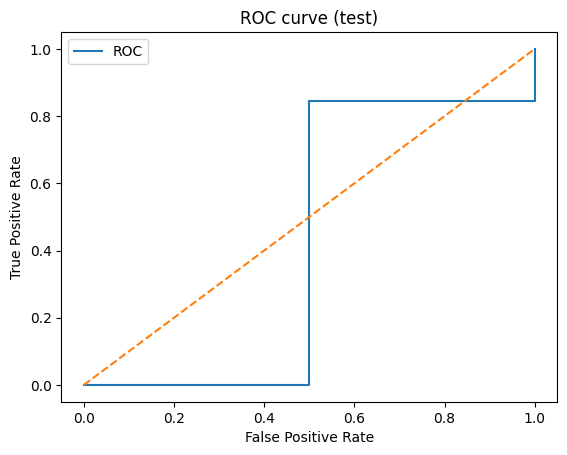

In [52]:
sk_log = LogisticRegression(max_iter=1000).fit(X_train, y_train_spend)

yhat_tr = sk_log.predict(X_train) # (predict using train X)
yhat_te = sk_log.predict(X_test) # (predict using test X)
proba_te = sk_log.predict_proba(X_test)[:, 1] # predict status = 1 probabilities

baseline_rate = y_test_spend.value_counts(normalize=True).max() # baseline rate for majority class accuracy
acc_tr = accuracy_score(y_train_spend, yhat_tr) # (train accuracy)
acc_te = accuracy_score(y_test_spend, yhat_te) # (test accuracy)
auc_te = roc_auc_score(y_test_spend, proba_te) # (roc auc test score)

print("Naive baseline (majority class accuracy):", round(baseline_rate, 3))
print(f"Accuracy (train): {acc_tr:.3f}")
print(f"Accuracy (test): {acc_te:.3f}")
print(f"AUC (test):      {auc_te:.3f}")

fpr, tpr, thr = roc_curve(y_test_spend, proba_te)
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test)')
plt.legend()
plt.show()

Naive baseline (majority class accuracy): 0.867
Accuracy (train): 0.286
Accuracy (test): 0.267
AUC (test):      0.500


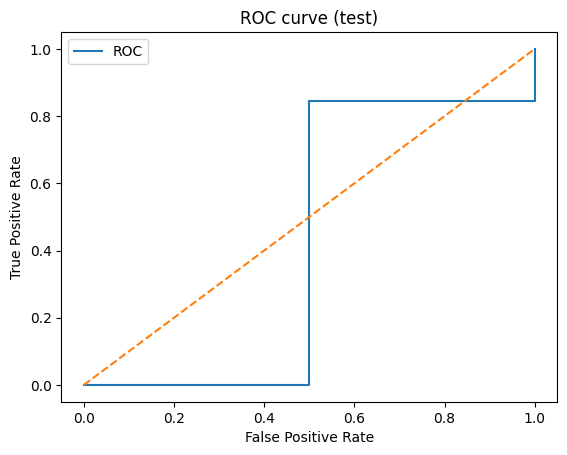

In [53]:
sk_log = LogisticRegression(max_iter=1000).fit(X_train, y_train_spend)

yhat_tr = sk_log.predict(X_train) # (predict using train X)
yhat_te = sk_log.predict(X_test) # (predict using test X)
proba_te = sk_log.predict_proba(X_test)[:, 1] # predict status = 1 probabilities

baseline_rate = y_test_spend.value_counts(normalize=True).max() # baseline rate for majority class accuracy
acc_tr = accuracy_score(y_train_emp, yhat_tr) # (train accuracy)
acc_te = accuracy_score(y_test_emp, yhat_te) # (test accuracy)
auc_te = roc_auc_score(y_test_emp, proba_te) # (roc auc test score)

print("Naive baseline (majority class accuracy):", round(baseline_rate, 3))
print(f"Accuracy (train): {acc_tr:.3f}")
print(f"Accuracy (test): {acc_te:.3f}")
print(f"AUC (test):      {auc_te:.3f}")

fpr, tpr, thr = roc_curve(y_test_spend, proba_te)
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test)')
plt.legend()
plt.show()